# Data Science Assesment

## Introduction

I took at the data over the last few days, however, with very little understanding of the data I wasted much of my time on the wrong features and only gained a little clarity earlier this week. I, however, made a few assumptions and scraped together semi-working credit risk model.

According to several financial institutions, they define delinquency or risk of default is the probability of a debtor failing to a payment on a credit product for a period of three months or more.

## Data Cleaning and Feature Engineering
- Using the report age in months, I generated an assumed date column. This column supposedly/assumed is the date when the report was generated for a user. Using this method, I detected the insights data were from 2019-12 to 2020-12.

- The Demographic Data and the Transactions Data is from 2019-12 to 2020-06. It made me sceptical about using the data as it only covered one period of the analysis. Using it would require an assumption thatthese values are stationery over the entire period of analysis.
- Looking at the insights data, I added a train/test column denoting the dates by the advised train/test period. I identified a column similar to the one in the targets CSV that shows if a user missed a payment or not for three months. 

I decomposed the data for each row to represent a user_id either for test/train data. I did this by:

- Generate one-hot encoding all object values 
- Removed nan columns with more than 50% of their rows
- removed any date columns
- removed 'statusThreePlus' (highly correlated to the target variable and produced skewed results) and made the 'statusThree' my target column
- Train test split based on the date

## Model Selection
I tested six models with the data to ascertain the general performance of each model classifier on the data.

- Logistic Regression
- K Neighbors Classifier
- Support Vector Classifier
- Naive Bayes Classifier
- Random Forest Classifier
- XGBoost Classifier

I knew I would use a tree classifier at the end of the day because I had a mixture of numerical and categorical variables. I was also sceptical about normalizing my dataset and how I would treat the nan values that I had left. There is always a misconception as to how well a model can decipher between zero and no data. Hence my choice of using a decision tree-based model.

- I used a binary logistic XGboost model as my choice of model with a bit of cross-validation using accuracy as my optimization evaluation metric.
- The aim is to generate a probability of how likely a customer will default on their account. As I defined initially, I considered 3 month of none payment as the definition of deliquency.

## Model Performance
Generally poor: ___train-auc:0.93761	eval-auc:0.83147___
### Reasons
- The model is not as accurate as I would like because of my 50/50 train/test.
- It needs more rows of data. I do not think six months of data is sufficient to give an accurate prediction of the next six month period.
- Enrich the data set with demographic data and Transaction data for the entire period.
## Explainability

I used shaply values to view how well my features are performing with regards to predictions. I understand financial regulation around the world are against black box prediction models .
- Shap values answer the “how much” each indivual feature is contributing to the overrall prediction using game theory. They are ideal for treebased models.


## Load Packages

In [3]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta, date
import calendar
import time
import os
import sys
import re
import warnings
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import model_selection
import graphviz
import shap 
#suppress warnings
warnings.filterwarnings('ignore')
#date function to generate dates for the insights data
def period(time_stamp, df):
    test_train_lbl =[]
    val = pd.to_datetime(df[time_stamp]).dt.strftime("%Y-%m-%d").values
    for i in val:
        if pd.to_datetime('2019-12-01')<= pd.to_datetime(i) <= pd.to_datetime('2020-05-31'):
            ttl = 'train'
            test_train_lbl.append(ttl)
        elif pd.to_datetime('2020-06-01')<= pd.to_datetime(i) <= pd.to_datetime('2020-12-31'):
            ttl = 'test'
            test_train_lbl.append(ttl)
        else:
            ttl = 'out of bound'
            test_train_lbl.append(ttl)
    df['test_train']= test_train_lbl
    return df
#test multiple models on data
def run_model(X_train,X_test,y_train,y_test):
    #models dictionary
    model_dict = [
             {'name':'Logistic Regression','model':LogisticRegression},
             {'name':'K Neighbors Classifier','model':KNeighborsClassifier},
             {'name':'Support Vector Classifier','model':SVC},
             {'name':'Naive Bayes Classifier','model':GaussianNB},
             {'name':'Random Forest Classifier','model':RandomForestClassifier},
             {'name':'XGBoost Classifier','model':XGBClassifier}
            ]
    #loop testing the data
    for classifier in model_dict:
        model = classifier['model']()
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print(f"{classifier['name']} score is ",model.score(X_test, y_test))
        print(f"{classifier['name']} Report\n", classification_report(y_pred,y_test))
        print(f"{classifier['name']} Confusion Matrix\n", confusion_matrix(y_pred,y_test))
        
        
#function to reduce memory of data frames     
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


## Load Data

In [4]:
df_insights = pd.read_csv('ds-tech-test-credit-insight.csv')
#df_demo = pd.read_csv('ds-tech-test-demographic.csv')
#df_trans = pd.read_csv('ds-tech-test-ob-transactions.csv')
df_targets = pd.read_csv('ds-tech-test-target.csv')

## Extract Features from the insights data

In [5]:
#Generate dates for when the insights reports
df_insights["assumed_date"] = pd.to_datetime(df_insights["pulled_timestamp"]) - pd.to_timedelta(df_insights['ageInMonths']*30, unit='D')
df_insights["assumed_date"] = pd.to_datetime(df_insights["assumed_date"]).dt.strftime('%Y-%m-%d')
df_insights = df_insights[['user_id','assumed_date','ageInMonths',
       'ageOfAccountInMonths', 'dataType',
       'balanceAmount', 'companyClass', 'creditLimitAmount', 'newlyOpened',
       'paymentFrequency','startBalance', 'statusOne', 'statusThree',
       'statusThreePlus', 'statusTwo', 'statusZeroOrBetter', 'utilisation'
       ]]

#create a seperation between test and training period
df_insights = period('assumed_date', df_insights)
# remove unneccesary data out of range
df_insights = df_insights[df_insights['test_train']!='out of bound']
#generate dummies for all object data types
df_insights_dummy = pd.get_dummies(df_insights, columns=["paymentFrequency",
                                       "newlyOpened","companyClass",
                                       "dataType"])
#remove generated date
df_insights_dummy = df_insights_dummy.drop(['assumed_date'], axis = 1)


In [6]:
#group data by user id and period
df_insights_dummy_grp = df_insights_dummy.groupby(['user_id','test_train']).agg({
    'ageInMonths':'max', 
    'ageOfAccountInMonths':'max', 
    'balanceAmount':'mean',
    'creditLimitAmount':'mean', 
    'startBalance':'mean', 
    'statusOne':'max', 
    'statusThree':'max',
    'statusThreePlus':'max', 
    'statusTwo':'max', 
    'statusZeroOrBetter':'max',
    'utilisation':'max',
    'paymentFrequency_ANNUALLY':'max',
    'paymentFrequency_FORTNIGHTLY':'max', 
    'paymentFrequency_MONTHLY':'max',
    'paymentFrequency_PERIODICALLY':'max', 'paymentFrequency_QUARTERLY':'max',
    'paymentFrequency_WEEKLY':'max', 'newlyOpened_False':'max', 'newlyOpened_True':'max',
    'companyClass_BF':'max', 'companyClass_BK':'max', 'companyClass_BS':'max',
    'companyClass_CB':'max', 'companyClass_CC':'max', 'companyClass_CH':'max',
    'companyClass_CS':'max', 'companyClass_DC':'max', 'companyClass_FN':'max',
    'companyClass_FS':'max', 'companyClass_HL':'max', 'companyClass_IN':'max',
    'companyClass_LG':'max', 'companyClass_MN':'max', 'companyClass_MO':'max',
    'companyClass_MS':'max', 'companyClass_PU':'max', 'companyClass_RN':'max',
    'companyClass_RT':'max', 'companyClass_SL':'max', 'dataType_bankDefaultAgreement':'max',
    'dataType_basicBankAccount':'max', 'dataType_bridgingFinance':'max',
    'dataType_budgetAccount':'max', 'dataType_chargeCard':'max',
    'dataType_commsSupplyAccount':'max', 'dataType_consolidatedDebt':'max',
    'dataType_creditCard':'max', 'dataType_currentAccount':'max',
    'dataType_fixedTermAgreement':'max', 'dataType_hirePurchase':'max',
    'dataType_homeLendingAgreement':'max', 'dataType_insuranceAgreement':'max',
    'dataType_mailOrderAccount':'max', 'dataType_optionAccount':'max',
    'dataType_payDayOrShortTermLoan':'max', 'dataType_propertyRental':'max',
    'dataType_publicUtilityAccount':'max', 'dataType_rentalAgreement':'max',
    'dataType_securedLoan':'max', 'dataType_unsecuredLoan':'max'}).reset_index()

#remove any user ids that fall into one period of analysis
df_user_id = pd.DataFrame(df_insights_dummy_grp['user_id'].value_counts()).reset_index()
df_user_id.columns = ['user_id','cnt']
df_user_id = df_user_id[df_user_id['cnt']==2]
list_user_id = df_user_id.user_id.values.tolist()
df_insights_dummy_grp = df_insights_dummy_grp[df_insights_dummy_grp['user_id'].isin(list_user_id)]

#assuming default window is 3 
df_insights_dummy_grp['default'] = df_insights_dummy_grp['statusThree']

df_insights_dummy_grp['creditLimitAmount'] = df_insights_dummy_grp.creditLimitAmount.astype(float)
df_insights_dummy_grp = df_insights_dummy_grp.drop('statusThreePlus', axis = 1)
df_insights_dummy_grp = reduce_mem_usage(df_insights_dummy_grp)

#remove none
df_insights_dummy_grp_no_nan = df_insights_dummy_grp.replace(np.nan,'0')
df_insights_dummy_grp_no_nan['creditLimitAmount'] = df_insights_dummy_grp_no_nan.creditLimitAmount.astype(float)
df_insights_dummy_grp_no_nan['utilisation'] = df_insights_dummy_grp_no_nan.utilisation.astype(float)
df_train = df_insights_dummy_grp_no_nan[df_insights_dummy_grp_no_nan['test_train']=='train']
df_test = df_insights_dummy_grp_no_nan[df_insights_dummy_grp_no_nan['test_train']=='test']

X_train = df_train[['ageInMonths', 'ageOfAccountInMonths',
       'balanceAmount', 'creditLimitAmount', 'startBalance', 'statusOne',
       'statusTwo', 'statusZeroOrBetter',
       'utilisation', 'paymentFrequency_ANNUALLY',
       'paymentFrequency_FORTNIGHTLY', 'paymentFrequency_MONTHLY',
       'paymentFrequency_PERIODICALLY', 'paymentFrequency_QUARTERLY',
       'paymentFrequency_WEEKLY', 'newlyOpened_False', 'newlyOpened_True',
       'companyClass_BF', 'companyClass_BK', 'companyClass_BS',
       'companyClass_CB', 'companyClass_CC', 'companyClass_CH',
       'companyClass_CS', 'companyClass_DC', 'companyClass_FN',
       'companyClass_FS', 'companyClass_HL', 'companyClass_IN',
       'companyClass_LG', 'companyClass_MN', 'companyClass_MO',
       'companyClass_MS', 'companyClass_PU', 'companyClass_RN',
       'companyClass_RT', 'companyClass_SL', 'dataType_bankDefaultAgreement',
       'dataType_basicBankAccount', 'dataType_bridgingFinance',
       'dataType_budgetAccount', 'dataType_chargeCard',
       'dataType_commsSupplyAccount', 'dataType_consolidatedDebt',
       'dataType_creditCard', 'dataType_currentAccount',
       'dataType_fixedTermAgreement', 'dataType_hirePurchase',
       'dataType_homeLendingAgreement', 'dataType_insuranceAgreement',
       'dataType_mailOrderAccount', 'dataType_optionAccount',
       'dataType_payDayOrShortTermLoan', 'dataType_propertyRental',
       'dataType_publicUtilityAccount', 'dataType_rentalAgreement',
       'dataType_securedLoan', 'dataType_unsecuredLoan']]
y_train = df_train['default'].values

X_test = df_test[['ageInMonths', 'ageOfAccountInMonths',
       'balanceAmount', 'creditLimitAmount', 'startBalance', 'statusOne',
       'statusTwo', 'statusZeroOrBetter',
       'utilisation', 'paymentFrequency_ANNUALLY',
       'paymentFrequency_FORTNIGHTLY', 'paymentFrequency_MONTHLY',
       'paymentFrequency_PERIODICALLY', 'paymentFrequency_QUARTERLY',
       'paymentFrequency_WEEKLY', 'newlyOpened_False', 'newlyOpened_True',
       'companyClass_BF', 'companyClass_BK', 'companyClass_BS',
       'companyClass_CB', 'companyClass_CC', 'companyClass_CH',
       'companyClass_CS', 'companyClass_DC', 'companyClass_FN',
       'companyClass_FS', 'companyClass_HL', 'companyClass_IN',
       'companyClass_LG', 'companyClass_MN', 'companyClass_MO',
       'companyClass_MS', 'companyClass_PU', 'companyClass_RN',
       'companyClass_RT', 'companyClass_SL', 'dataType_bankDefaultAgreement',
       'dataType_basicBankAccount', 'dataType_bridgingFinance',
       'dataType_budgetAccount', 'dataType_chargeCard',
       'dataType_commsSupplyAccount', 'dataType_consolidatedDebt',
       'dataType_creditCard', 'dataType_currentAccount',
       'dataType_fixedTermAgreement', 'dataType_hirePurchase',
       'dataType_homeLendingAgreement', 'dataType_insuranceAgreement',
       'dataType_mailOrderAccount', 'dataType_optionAccount',
       'dataType_payDayOrShortTermLoan', 'dataType_propertyRental',
       'dataType_publicUtilityAccount', 'dataType_rentalAgreement',
       'dataType_securedLoan', 'dataType_unsecuredLoan',]]
y_test = df_test['default'].values


Memory usage after optimization is: 0.98 MB
Decreased by 42.2%


In [7]:
#model = LogisticRegression()
#model.fit(X_train,y_train)
#y_pred = model.predict(X_test)
#print("model score is ",model.score(X_test, y_test))
#print("model Report\n", classification_report(y_pred,y_test))
#print("model Confusion Matrix\n", confusion_matrix(y_pred,y_test))
#cm = confusion_matrix(y_pred,y_test)

## Run the model (train and test)

In [8]:
run_model(X_train,X_test,y_train,y_test)

Logistic Regression score is  0.899621553433051
Logistic Regression Report
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      4947
           1       0.56      0.37      0.44       602

    accuracy                           0.90      5549
   macro avg       0.74      0.67      0.69      5549
weighted avg       0.89      0.90      0.89      5549

Logistic Regression Confusion Matrix
 [[4770  177]
 [ 380  222]]
K Neighbors Classifier score is  0.926112813119481
K Neighbors Classifier Report
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      5522
           1       0.02      0.30      0.04        27

    accuracy                           0.93      5549
   macro avg       0.51      0.61      0.50      5549
weighted avg       0.99      0.93      0.96      5549

K Neighbors Classifier Confusion Matrix
 [[5131  391]
 [  19    8]]
Support Vector Classifier score is  0.9280951522796901


### Best Model
 - Based on the information above the tree based models perform better than the other model
 - I am going to use XGBoost to train the model and use shap as the explainer

In [9]:
#df_insights_dummy_grp_no_nan = df_insights_dummy_grp.replace(np.nan,'0')
df_train = df_insights_dummy_grp[df_insights_dummy_grp['test_train']=='train']
df_test = df_insights_dummy_grp[df_insights_dummy_grp['test_train']=='test']

X_train = df_train[['ageInMonths', 'ageOfAccountInMonths',
       'balanceAmount', 'creditLimitAmount', 'startBalance', 'statusOne',
       'statusTwo', 'statusZeroOrBetter',
       'utilisation', 'paymentFrequency_ANNUALLY',
       'paymentFrequency_FORTNIGHTLY', 'paymentFrequency_MONTHLY',
       'paymentFrequency_PERIODICALLY', 'paymentFrequency_QUARTERLY',
       'paymentFrequency_WEEKLY', 'newlyOpened_False', 'newlyOpened_True',
       'companyClass_BF', 'companyClass_BK', 'companyClass_BS',
       'companyClass_CB', 'companyClass_CC', 'companyClass_CH',
       'companyClass_CS', 'companyClass_DC', 'companyClass_FN',
       'companyClass_FS', 'companyClass_HL', 'companyClass_IN',
       'companyClass_LG', 'companyClass_MN', 'companyClass_MO',
       'companyClass_MS', 'companyClass_PU', 'companyClass_RN',
       'companyClass_RT', 'companyClass_SL', 'dataType_bankDefaultAgreement',
       'dataType_basicBankAccount', 'dataType_bridgingFinance',
       'dataType_budgetAccount', 'dataType_chargeCard',
       'dataType_commsSupplyAccount', 'dataType_consolidatedDebt',
       'dataType_creditCard', 'dataType_currentAccount',
       'dataType_fixedTermAgreement', 'dataType_hirePurchase',
       'dataType_homeLendingAgreement', 'dataType_insuranceAgreement',
       'dataType_mailOrderAccount', 'dataType_optionAccount',
       'dataType_payDayOrShortTermLoan', 'dataType_propertyRental',
       'dataType_publicUtilityAccount', 'dataType_rentalAgreement',
       'dataType_securedLoan', 'dataType_unsecuredLoan']]
y_train = df_train['default'].values

X_test = df_test[['ageInMonths', 'ageOfAccountInMonths',
       'balanceAmount', 'creditLimitAmount', 'startBalance', 'statusOne',
       'statusTwo', 'statusZeroOrBetter',
       'utilisation', 'paymentFrequency_ANNUALLY',
       'paymentFrequency_FORTNIGHTLY', 'paymentFrequency_MONTHLY',
       'paymentFrequency_PERIODICALLY', 'paymentFrequency_QUARTERLY',
       'paymentFrequency_WEEKLY', 'newlyOpened_False', 'newlyOpened_True',
       'companyClass_BF', 'companyClass_BK', 'companyClass_BS',
       'companyClass_CB', 'companyClass_CC', 'companyClass_CH',
       'companyClass_CS', 'companyClass_DC', 'companyClass_FN',
       'companyClass_FS', 'companyClass_HL', 'companyClass_IN',
       'companyClass_LG', 'companyClass_MN', 'companyClass_MO',
       'companyClass_MS', 'companyClass_PU', 'companyClass_RN',
       'companyClass_RT', 'companyClass_SL', 'dataType_bankDefaultAgreement',
       'dataType_basicBankAccount', 'dataType_bridgingFinance',
       'dataType_budgetAccount', 'dataType_chargeCard',
       'dataType_commsSupplyAccount', 'dataType_consolidatedDebt',
       'dataType_creditCard', 'dataType_currentAccount',
       'dataType_fixedTermAgreement', 'dataType_hirePurchase',
       'dataType_homeLendingAgreement', 'dataType_insuranceAgreement',
       'dataType_mailOrderAccount', 'dataType_optionAccount',
       'dataType_payDayOrShortTermLoan', 'dataType_propertyRental',
       'dataType_publicUtilityAccount', 'dataType_rentalAgreement',
       'dataType_securedLoan', 'dataType_unsecuredLoan',]]
y_test = df_test['default'].values


In [10]:
#parameters for the model
params = {"objective": "binary:logistic",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 45,
          "subsample": 0.9,
          "colsample_bytree": 0.8
          }

num_boost_round = 1000
#evalaluation metric for optimization
params['eval_metric']="auc"

print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=50, verbose_eval=True)

d_test = xgb.DMatrix(X_test)
y_pred = gbm.predict(d_test)
result = pd.DataFrame({'actual': y_test, 'predicted': y_pred})



Train a XGBoost model
[0]	train-auc:0.80413	eval-auc:0.77885
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.87857	eval-auc:0.80726
[2]	train-auc:0.90753	eval-auc:0.82454
[3]	train-auc:0.91649	eval-auc:0.82341
[4]	train-auc:0.93761	eval-auc:0.83147
[5]	train-auc:0.96606	eval-auc:0.83026
[6]	train-auc:0.97284	eval-auc:0.82997
[7]	train-auc:0.97454	eval-auc:0.82246
[8]	train-auc:0.98118	eval-auc:0.82266
[9]	train-auc:0.98334	eval-auc:0.82340
[10]	train-auc:0.98647	eval-auc:0.82527
[11]	train-auc:0.99200	eval-auc:0.82393
[12]	train-auc:0.99366	eval-auc:0.82114
[13]	train-auc:0.99485	eval-auc:0.82251
[14]	train-auc:0.99650	eval-auc:0.82050
[15]	train-auc:0.99728	eval-auc:0.81896
[16]	train-auc:0.99814	eval-auc:0.81804
[17]	train-auc:0.99887	eval-auc:0.81748
[18]	train-auc:0.99919	eval-auc:0.81971
[19]	train-auc:0.99936	eval-auc:0.82042
[20]	train-auc:0.99963	eval-auc:0.81869
[21]	tr

## Explainability

In [11]:
#generate a dfmatrix for running explainer
x = df_insights_dummy_grp[['ageInMonths', 'ageOfAccountInMonths',
       'balanceAmount', 'creditLimitAmount', 'startBalance', 'statusOne',
       'statusTwo', 'statusZeroOrBetter',
       'utilisation', 'paymentFrequency_ANNUALLY',
       'paymentFrequency_FORTNIGHTLY', 'paymentFrequency_MONTHLY',
       'paymentFrequency_PERIODICALLY', 'paymentFrequency_QUARTERLY',
       'paymentFrequency_WEEKLY', 'newlyOpened_False', 'newlyOpened_True',
       'companyClass_BF', 'companyClass_BK', 'companyClass_BS',
       'companyClass_CB', 'companyClass_CC', 'companyClass_CH',
       'companyClass_CS', 'companyClass_DC', 'companyClass_FN',
       'companyClass_FS', 'companyClass_HL', 'companyClass_IN',
       'companyClass_LG', 'companyClass_MN', 'companyClass_MO',
       'companyClass_MS', 'companyClass_PU', 'companyClass_RN',
       'companyClass_RT', 'companyClass_SL', 'dataType_bankDefaultAgreement',
       'dataType_basicBankAccount', 'dataType_bridgingFinance',
       'dataType_budgetAccount', 'dataType_chargeCard',
       'dataType_commsSupplyAccount', 'dataType_consolidatedDebt',
       'dataType_creditCard', 'dataType_currentAccount',
       'dataType_fixedTermAgreement', 'dataType_hirePurchase',
       'dataType_homeLendingAgreement', 'dataType_insuranceAgreement',
       'dataType_mailOrderAccount', 'dataType_optionAccount',
       'dataType_payDayOrShortTermLoan', 'dataType_propertyRental',
       'dataType_publicUtilityAccount', 'dataType_rentalAgreement',
       'dataType_securedLoan', 'dataType_unsecuredLoan']]
y = df_insights_dummy_grp['default'].values
df_dmatrix=xgb.DMatrix(data=x, label=y)

In [12]:
params =  {"objective":"binary:logistic",
           "booster" : "gbtree",
           "eta": 0.3,
           "max_depth": 45,
           "subsample": 0.9,
           "colsample_bytree": 0.8,
           "learning_rate":0.01}

cv_results =xgb.cv(dtrain= df_dmatrix, 
                   params = params, 
                   nfold =10, 
                   num_boost_round = 10, 
                   early_stopping_rounds=50, 
                   metrics='auc', 
                   as_pandas =True, seed =1301)

xg_clr = xgb.train(params = params, dtrain = df_dmatrix,num_boost_round = 600)

### Using importance of features

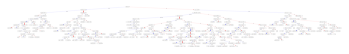

In [13]:
xgb.plot_tree(xg_clr,num_trees = 0)
plt.rcParams['figure.figsize']=[50,50]
plt.show()

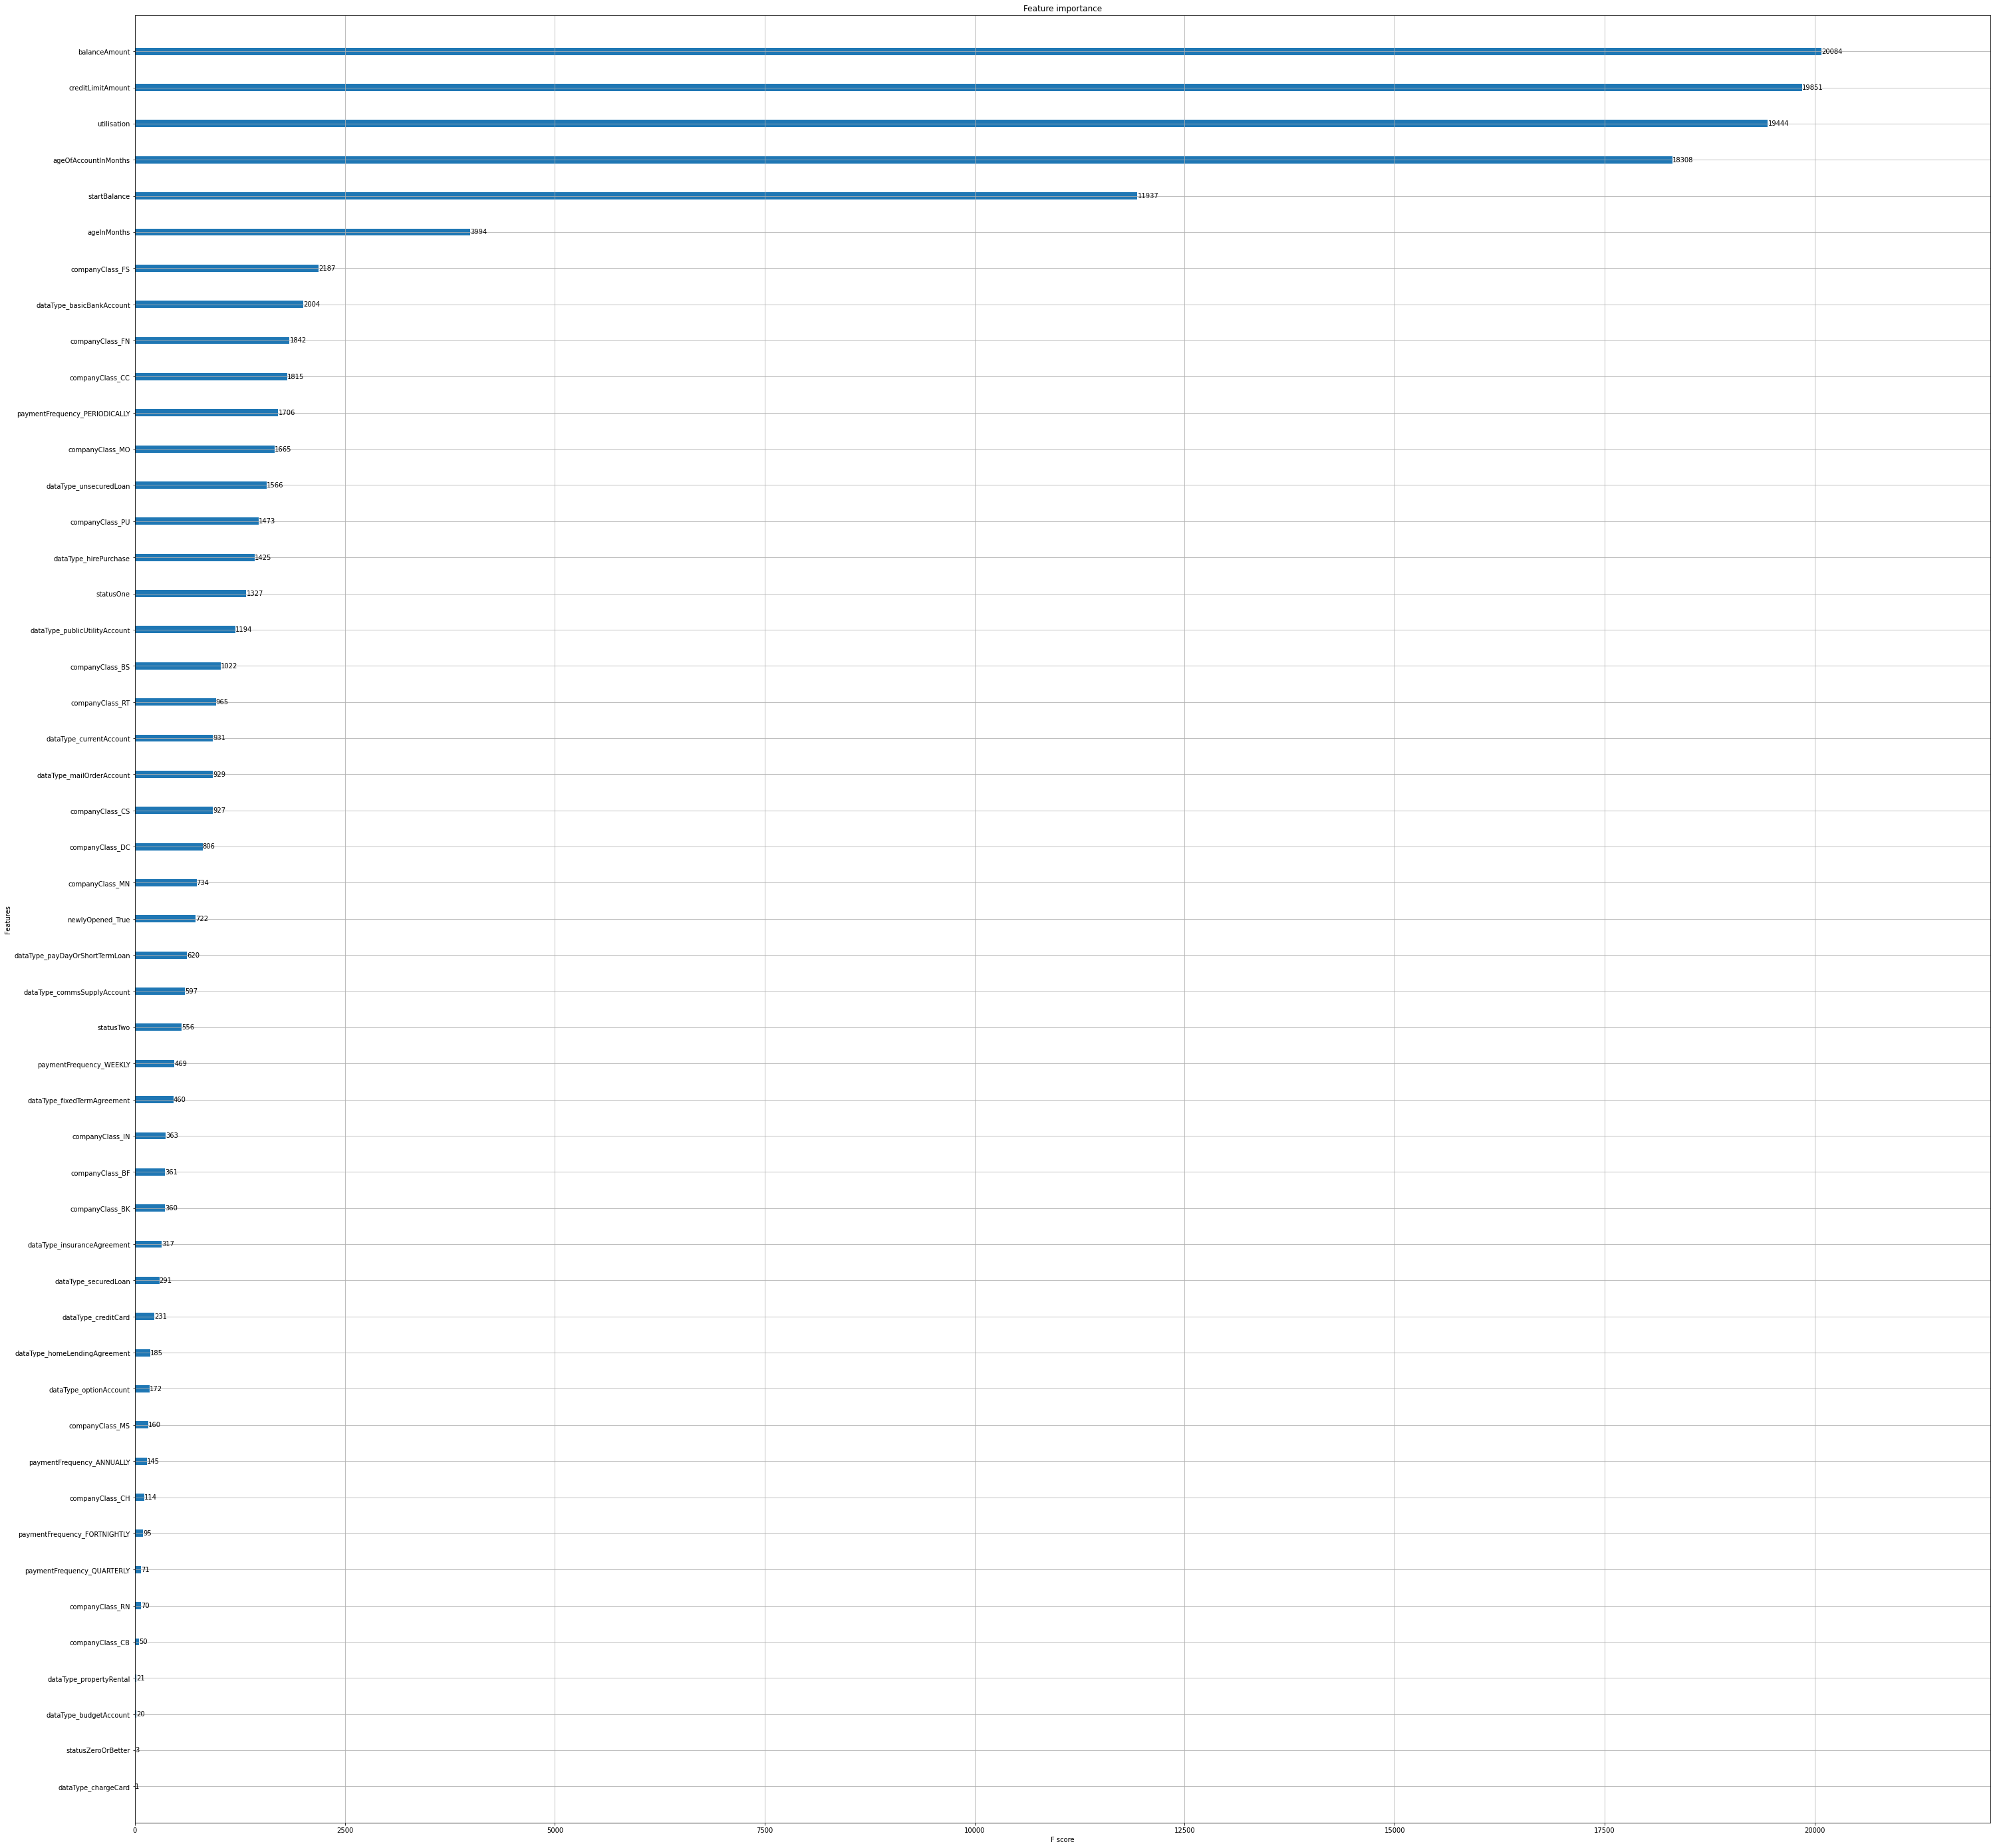

In [14]:
xgb.plot_importance(xg_clr)
plt.rcParams['figure.figsize']=[50,50]
plt.show()

### Using Shape Values

In [15]:
#shows first prediction values and contribution of shap values to overall prediction
shap.initjs()
explainer = shap.TreeExplainer(xg_clr)
shap_values = explainer.shap_values(x)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:])

#### Bar plot of the average contribution of features

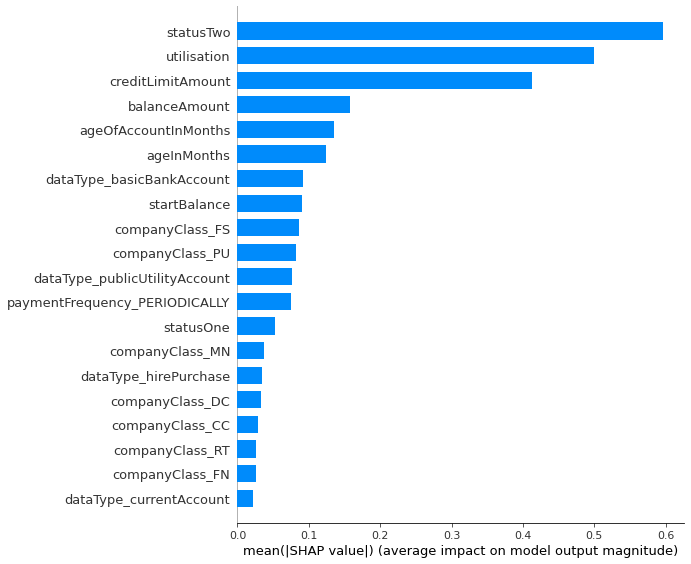

In [16]:
shap.summary_plot(shap_values, x, plot_type='bar')

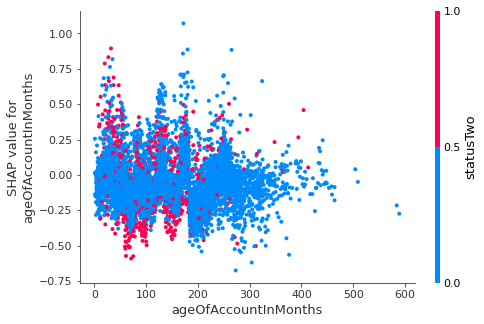

In [17]:
shap.dependence_plot(1, shap_values, x)

In [ ]:
df_test[df_test['default']==1][['default','rounded_pred']].sum()

In [ ]:
df_comb = df_test.merge(df_targets[['user_id','defaultInWindow','twoPlusInWindow']], 
                        on = 'user_id', 
                        how = 'left')[['user_id','default','defaultInWindow','twoPlusInWindow','predicted','rounded_pred']]


In [ ]:
df_comb